<a href="https://colab.research.google.com/github/elmomote/DL2024-FacialKeypointDetectionProject/blob/main/%5BF24_DL%5D_Facial_Keypoint_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **The Project**

The Facial Keypoint Detection Competition from Kaggle consists of creating a model that receives grayscale images of shape 96x96 and make 30 predictions based on those images.

### **The Plan**

The plan in this project is to split up and make two models. Try our best, make some good documentation, and at the end. Observe the best out of both models to make one final model.

# Loading Data set from Kaggle

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip
!unzip training.zip
!unzip test.zip


Saving kaggle.json to kaggle.json
 87% 66.0M/76.3M [00:01<00:00, 63.6MB/s]
100% 76.3M/76.3M [00:01<00:00, 67.4MB/s]
Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


## Sample Image

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
image_index = 0  # Change this to display a different image
image = data['Image'][image_index].reshape(96, 96)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Sample Training Image")
plt.show()


## Sample Image with Key points

In [ ]:
keypoints = data.iloc[image_index, :-1].values  # All columns except the 'Image'
keypoints = keypoints.astype(float).reshape(-1, 2)  # Reshape into (x, y) pairs

plt.imshow(image, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='red', marker='o')
plt.axis('off')
plt.title("Training Image with Keypoints")
plt.show()


# Model 1
Conducted by Anaiah Quinn

In [ ]:
# Load and preprocess data
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
data.dropna(inplace=True)  # Drop rows with missing keypoints

# Prepare input and output
images = np.stack(data['Image'].values).reshape(-1, 96, 96, 1) / 255.0  # Normalize pixel values
keypoints = data.drop(columns=['Image']).values  # Keypoints as targets

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, keypoints, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(30)  # 15 keypoints * 2 coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Visualize predictions
def visualize_predictions(index):
    img = X_val[index].reshape(96, 96)
    true_keypoints = y_val[index].reshape(-1, 2)
    predicted_keypoints = model.predict(X_val[index:index+1]).reshape(-1, 2)

    plt.imshow(img, cmap='gray')
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], c='green', label='True', s=20)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='red', label='Predicted', s=20)
    plt.legend()
    plt.title('True vs Predicted Keypoints')
    plt.axis('off')
    plt.show()

# Visualize predictions for a random sample
visualize_predictions(0)  # Change the index to view other samples


# Model 2
Conducted by Alan Gonzalez

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Preparing the training data

In [3]:
training_data = pd.read_csv('training.csv')

training_data.dropna(inplace=True)

def process_image_data(image_str):
  return np.fromstring(image_str, sep=' ')

def reshape_image(image_array):
  return image_array.reshape(96, 96)

'''
  FOR IMAGE INPUTS
'''


training_data['Image'] = training_data['Image'].map(process_image_data)

training_data['Image'] = training_data['Image'].map(reshape_image)

training_images = np.stack(training_data['Image'].to_numpy())

# Normalize pixel values to the range [0, 1]
training_images = training_images / 255.0

'''
  FOR COORDINATE OUTPUTS
'''
coordinate_columns = training_data.columns.difference(['Image'])

training_coordinates = training_data[coordinate_columns].to_numpy()

# Normalize coordinates to the range [0,1]
training_coordinates /= 96.0

Visualize for sanity. With and without keypoints.

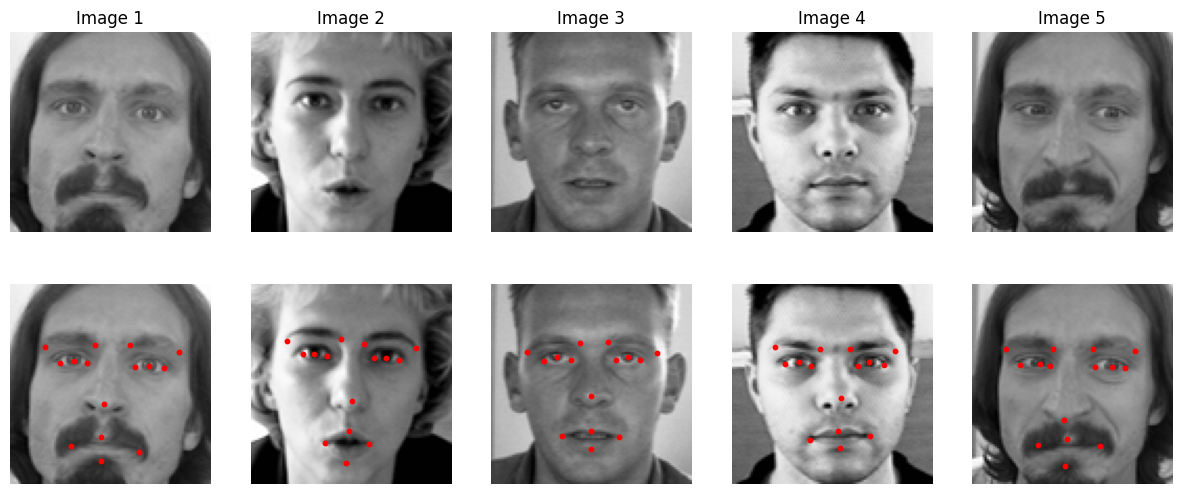

In [4]:
# Number of examples to display
num_examples = 5

# Set up the figure with two rows: one for images, one for images with keypoints
fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

for i in range(num_examples):
    # Select an image and its keypoints
    image = training_images[i]
    keypoints = training_coordinates[i] * 96.0

    # First row: Display the image without keypoints
    ax = axes[0, i]
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Turn off the axis
    ax.set_title(f"Image {i+1}")

    # Second row: Display the image with keypoints
    ax = axes[1, i]
    ax.imshow(image, cmap='gray')
    for j in range(0, len(keypoints), 2):  # Loop through x, y pairs
        x = keypoints[j]
        y = keypoints[j + 1]
        ax.scatter(x, y, c='red', s=10)  # Plot keypoints as red dots
    ax.axis('off')  # Turn off the axis

# Adjust layout to avoid overlap
plt.show()

Create a 80/20 split on the training data, only use test data to visually compare after training.

In [5]:
split_index = int(len(training_images) * 0.8)

x_train = training_images[:split_index]
x_test = training_images[split_index:]
y_train = training_coordinates[:split_index]
y_test = training_coordinates[split_index:]

print('Training inputs shape:', x_train.shape)
print('Validation input shape:', x_test.shape)
print('Training outputs shape:', y_train.shape)
print('Validation output shpe:', y_test.shape)

Training inputs shape: (1712, 96, 96)
Validation input shape: (428, 96, 96)
Training outputs shape: (1712, 30)
Validation output shpe: (428, 30)


New dataset was severely affected by the removal of null/nan values, but
fabricating new values to replace the nulls seemed like a worse idea just to get more "data".

**[Attempt 1]**


Creating a simple convolutional model with 32, 16, and 8 filters. Adding option to modify filters if needed.

In [6]:
def m2_simple_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [7]:
m2_attempt_1 = m2_simple_convolution()
m2_attempt_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │       2,211,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,217,974 (8.46 MB)

 Trainable params: 2,217,974 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

Create a loss function that measures the distances between the predicted and actual values. Using euclidean distances from the first homework.

In [8]:
def m2_euclidean_distance_loss(predicted, actual):
  differences = actual - predicted
  squared_differences = tf.square(differences)
  squared_distances = tf.reduce_sum(squared_differences, axis = 1)
  distances = tf.sqrt(squared_distances)
  return tf.reduce_mean(distances)

Compile the model with the distance loss function. Using the adam optimizer because its commonly used.

In [9]:
m2_attempt_1.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss,
)

Training the model with the obtained training and validation data. First try showed that the dataset had null values, so I had to remove them on the preparation.

In [ ]:
m2_attempt_1_history = m2_attempt_1.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1
)

Attempt abandoned due to long training time.

**[Attempt 2]**

Reduce the number of parameters needed to reduce training time. Idea: Add average pooling to reduce dimensions.

In [10]:
def m2_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [11]:
m2_attempt_2 = m2_convolution()
m2_attempt_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

**Adding early stopping**
Decided to add the callback since attempt 2 validation loss was not improving significantly, to save time.

In [12]:
m2_attempt_2.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_2_history = m2_attempt_2.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - loss: 0.4769 - val_loss: 0.1967
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - loss: 0.1576 - val_loss: 0.1913
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - loss: 0.1428 - val_loss: 0.1889
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - loss: 0.1346 - val_loss: 0.1851
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - loss: 0.1308 - val_loss: 0.1783
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - loss: 0.1224 - val_loss: 0.1738
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - loss: 0.1112 - val_loss: 0.1741
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - loss: 0.1047 - val_loss: 0.1677
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - loss: 0.0997 - val_loss: 0.1635
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - loss: 0.0988 - val_loss: 0.1593
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - loss: 0.0942 - val_loss: 0.1609
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12

Bringing the method to plot loss from previous homeworks.

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

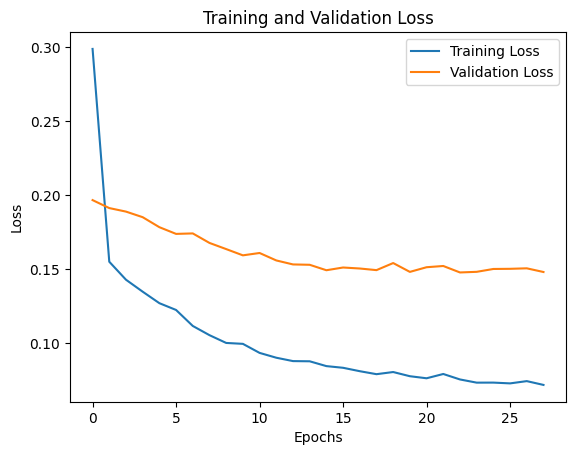

In [14]:
plot_loss(m2_attempt_2_history)

The loss behavior seems extremely unusual, lets check out the predictions.

In [15]:
def m2_evaluate_model(model):
  indices = [0,1,2]

  example_images = x_test[indices]

  true_keypoints = y_test[indices]
  predicted_keypoints = model.predict(example_images)

  # Rescale for image use
  true_keypoints *= 96.0
  predicted_keypoints *= 96.0

  print('True Keypoints:')

  fig, axes = plt.subplots(1, len(indices), figsize=(15, 6))

  for i in range(len(indices)):
      ax = axes[i]
      ax.imshow(example_images[i], cmap='gray')

      # Plot true keypoints
      ax.scatter(true_keypoints[i][::2], true_keypoints[i][1::2],
                c='green', s=10)

      ax.axis('off')

  plt.show()

  print('Predicted Keypoints:')

  fig, axes = plt.subplots(1, len(indices), figsize=(15, 6))

  for i in range(len(indices)):
    ax = axes[i]
    ax.imshow(example_images[i], cmap='gray')

    # Plot predicted keypoints
    ax.scatter(predicted_keypoints[i][::2], predicted_keypoints[i][1::2],
              c='red', s=10)

    ax.axis('off')

  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
True Keypoints:


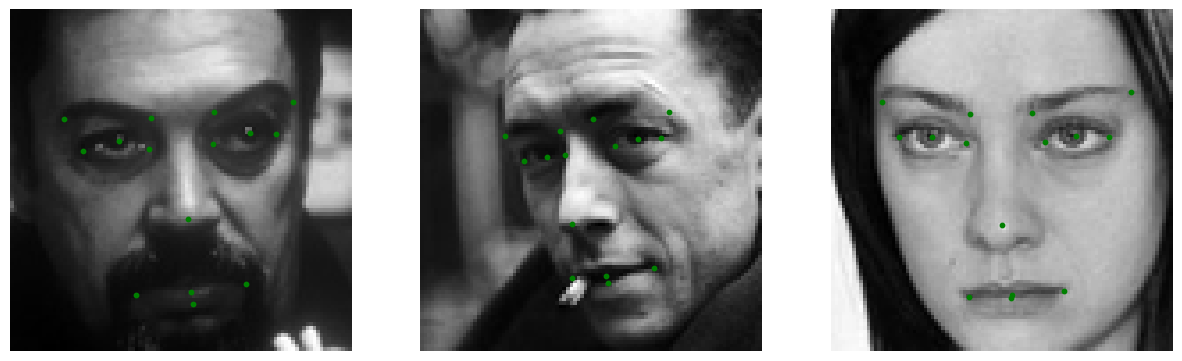

Predicted Keypoints:


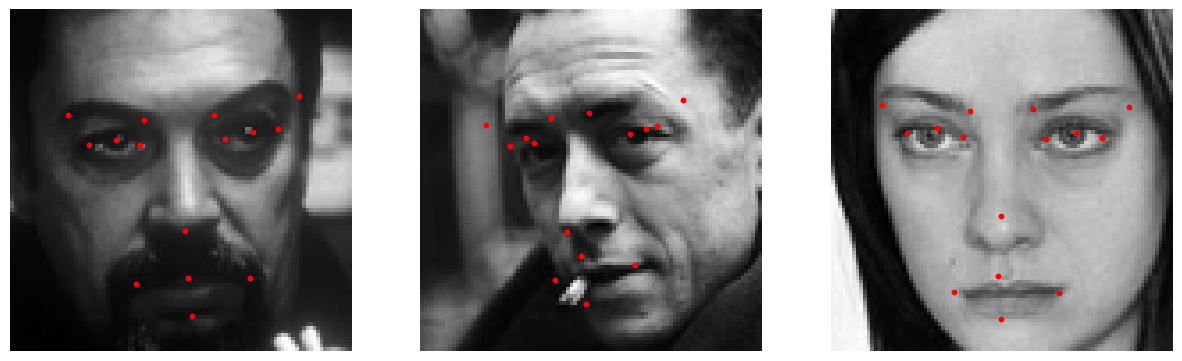

In [16]:
m2_evaluate_model(m2_attempt_2)

It seems its placing the prediction keypoints in the same place for every image, lets check it out.

Define a function that prints all the predicted keypoints for x_test to see if there is a difference in the predictions or they are all the same.

In [17]:
def plot_all_keypoint_predictions(model, x_test):
  predicted_keypoints_all = model.predict(x_test)

  predicted_keypoints_all *= 96.0

  fig, ax = plt.subplots(figsize=(3,3))

  for predicted_keypoints in predicted_keypoints_all:
    x_coords = predicted_keypoints[::2]
    y_coords = predicted_keypoints[1::2]

    # Invert y-coordinates
    y_coords = 96 - y_coords

    ax.scatter(x_coords, y_coords, s=10)

  # Set plot labels and title
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title("Predicted Keypoints for All Images")

  # Show the plot
  plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


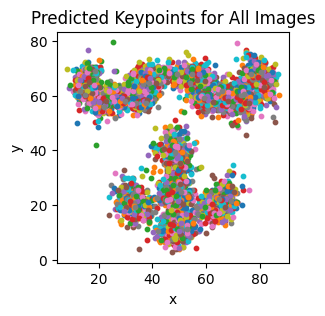

In [18]:
plot_all_keypoint_predictions(m2_attempt_2, x_test)

The keypoints seem to always be in a certain area but with some variation,
maybe its the nature of the data.

Idea: add more data with augmentations

Rotation might be possible but too complicated or might require unfamiliar tools.

Horizontal flip possible.

In [19]:
def flip_images_and_keypoints(input_images, output_keypoints):
  flipped_images = np.flip(input_images, axis = 2)

  flipped_keypoints = output_keypoints.copy()

  # Rescale
  flipped_keypoints *= 96

  for keypoints in flipped_keypoints:
    for i in range(0, 30, 2):
      keypoints[i] = 96 - keypoints[i]

  # Normalize
  flipped_keypoints /= 96.0

  return flipped_images, flipped_keypoints

Get a flipped set based on the training set.

In [20]:
x_train_flipped, y_train_flipped = flip_images_and_keypoints(x_train, y_train)

Observe the outputs

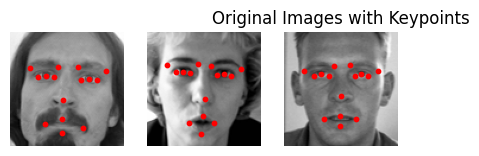

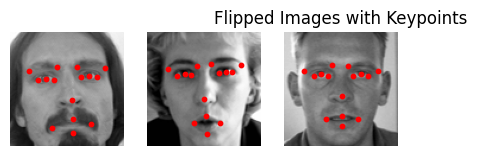

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(5,5))
plt.title("Original Images with Keypoints")

for i in range(3):
  ax[i].imshow(x_train[i], cmap='gray')
  ax[i].axis('off')
  ax[i].scatter(y_train[i][::2] * 96.0, y_train[i][1::2] * 96.0, c='red', s=10)

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(5,5))
plt.title("Flipped Images with Keypoints")

for i in range(3):
  ax[i].imshow(x_train_flipped[i], cmap='gray')
  ax[i].axis('off')
  ax[i].scatter(y_train_flipped[i][::2] * 96.0, y_train_flipped[i][1::2] * 96.0, c='red', s=10)

plt.show()

Create augmented data set. More augmentations like noise, brightness, and contrast will be added with layers.

In [22]:
x_train_augmented = np.concatenate((x_train, x_train_flipped))
y_train_augmented = np.concatenate((y_train, y_train_flipped))

print('Augmented x train shape:', x_train_augmented.shape)
print('Augmented y train shape:', y_train_augmented.shape)

Augmented x train shape: (3424, 96, 96)
Augmented y train shape: (3424, 30)


**[Attempt 3]**
Add remaning augmentations to the previous model.

In [23]:
def m2_augmented_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

  # Final layer to get the same output shape
  model.add(
    tf.keras.layers.Conv2D(
      1,
      kernel_size = (3, 3),
      padding = 'same'
    )
  )

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [24]:
m2_attempt_3 = m2_augmented_convolution()
m2_attempt_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness (RandomBrightness) │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 48, 48, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 1)           │              73 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           4,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,527 (41.12 KB)

 Trainable params: 10,527 (41.12 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
m2_attempt_3.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_3_history = m2_attempt_3.fit(
  x = x_train_augmented,
  y = y_train_augmented,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - loss: 1.2506 - val_loss: 1.0337
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 265ms/step - loss: 0.7163 - val_loss: 1.3535
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - loss: 0.6537 - val_loss: 1.3462
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.6359 - val_loss: 1.3664
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - loss: 0.6137 - val_loss: 1.3775
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - loss: 0.6311 - val_loss: 1.3557


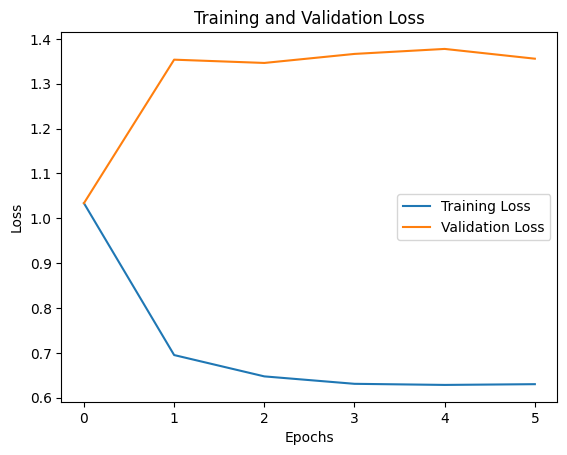

In [26]:
plot_loss(m2_attempt_3_history)

The graph indicates immediate overfitting with very obvious plateaus.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
True Keypoints:


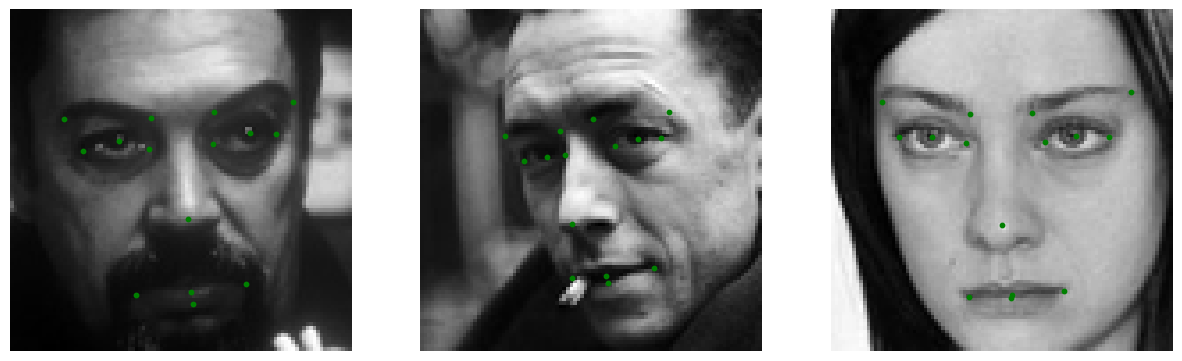

Predicted Keypoints:


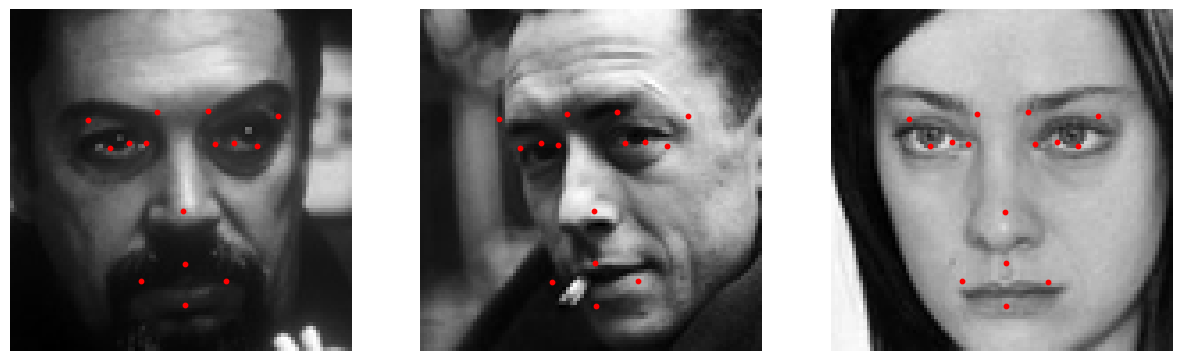

In [27]:
m2_evaluate_model(m2_attempt_3)

Even though the validation loss seems higher, the visual results have more variation. Lets observe overall spread.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


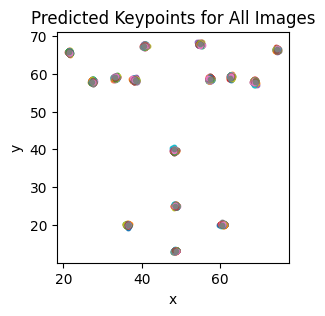

In [28]:
plot_all_keypoint_predictions(m2_attempt_3, x_test)

The spread shows the predictions are not as spread out which confirms the overfitting.

**[Attempt 4]**

Idea: Adding dropout and activations. Remove flip augmentation.

In [29]:
def m2_convolution_2(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [30]:
m2_attempt_4 = m2_convolution_2()
m2_attempt_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_1                  │ (None, 96, 96, 1)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 48, 48, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

Train without x_train_augmented

In [31]:
m2_attempt_4.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_4_history = m2_attempt_4.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - loss: 1.1040 - val_loss: 0.6133
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step - loss: 0.3148 - val_loss: 0.2020
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - loss: 0.1753 - val_loss: 0.1913
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step - loss: 0.1691 - val_loss: 0.1926
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - loss: 0.1673 - val_loss: 0.1923
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - loss: 0.1629 - val_loss: 0.1877
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - loss: 0.1592 - val_loss: 0.1850
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - loss: 0.1575 - val_loss: 0.1910
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - loss: 0.1583 - val_loss: 0.1890
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - loss: 0.1597 - val_loss: 0.1925
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - loss: 0.1581 - val_loss: 0.1912
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15

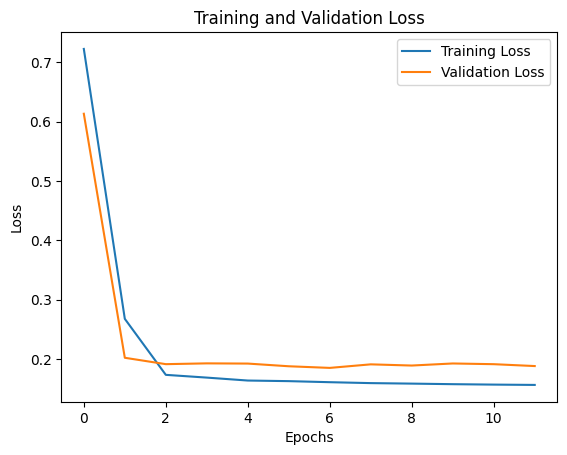

In [32]:
plot_loss(m2_attempt_4_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True Keypoints:


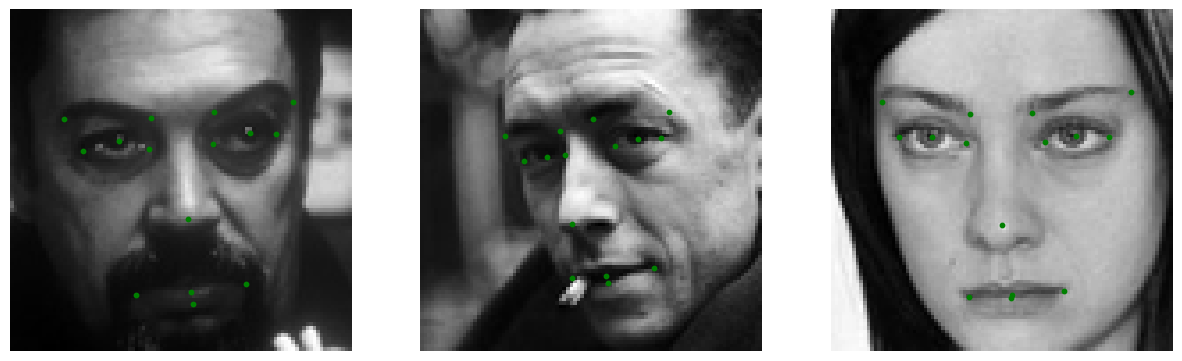

Predicted Keypoints:


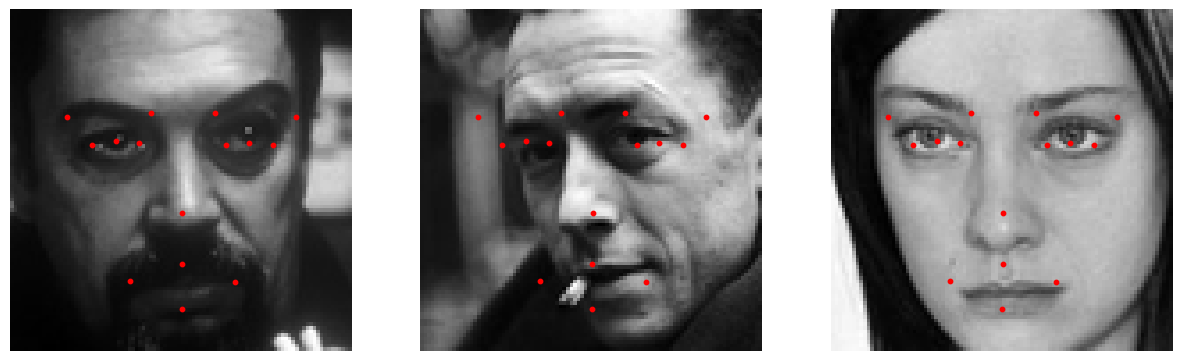

In [33]:
m2_evaluate_model(m2_attempt_4)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


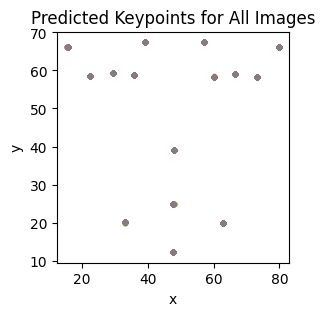

In [34]:
plot_all_keypoint_predictions(m2_attempt_4, x_test)

New points seem extremely focused which might be bad.

**[Attempt 5]**

Last attempt before giving up.

Idea: Swap average pooling by max pooling.

In [35]:
def m2_convolution_3(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [36]:
m2_attempt_5 = m2_convolution_3()
m2_attempt_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_2                  │ (None, 96, 96, 1)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_2 (RandomContrast)   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_2 (GaussianNoise)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
m2_attempt_5.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_5_history = m2_attempt_5.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - loss: 1.1269 - val_loss: 0.7877
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 379ms/step - loss: 0.3214 - val_loss: 0.2045
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - loss: 0.1791 - val_loss: 0.1942
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - loss: 0.1696 - val_loss: 0.1881
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - loss: 0.1641 - val_loss: 0.1884
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - loss: 0.1620 - val_loss: 0.1918
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 462ms/step - loss: 0.1623 - val_loss: 0.1899
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - loss: 0.1595 - val_loss: 0.1906
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - loss: 0.1580 - val_loss: 0.1902


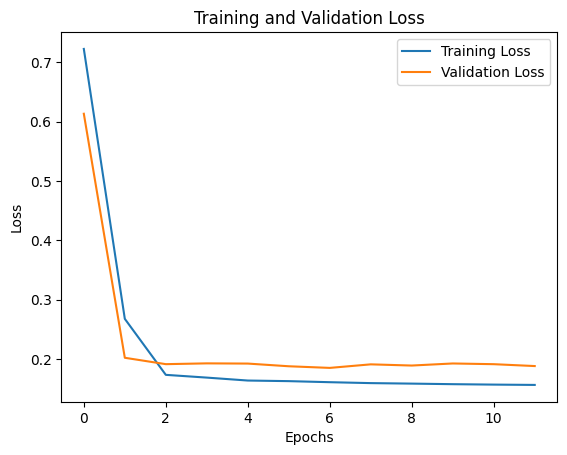

In [38]:
plot_loss(m2_attempt_4_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
True Keypoints:


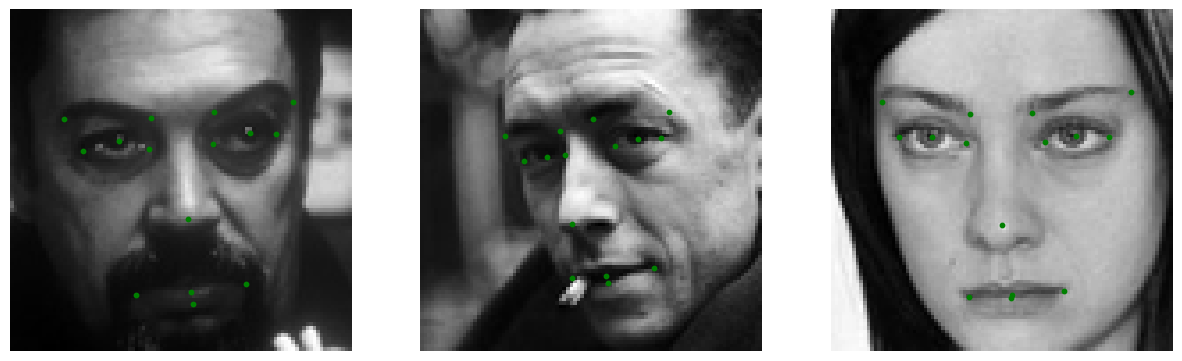

Predicted Keypoints:


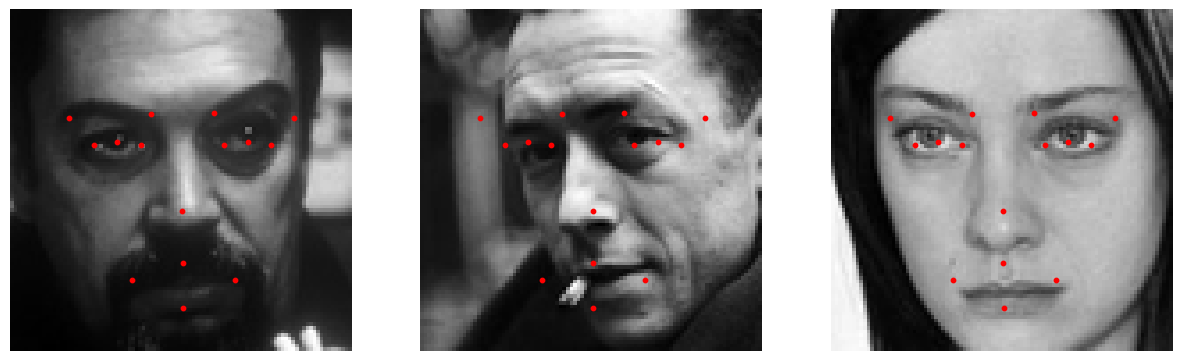

In [39]:
m2_evaluate_model(m2_attempt_5)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


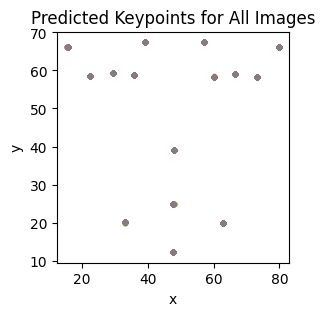

In [40]:
plot_all_keypoint_predictions(m2_attempt_4, x_test)